# Anchor Boxes Analysis using K-Means

### Section 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

### with Image resizing (correct way!)

#### Read csv
A csv was made from xml file using "xml_to_csv.py"

In [38]:
#Read the dataset
data = pd.read_csv('images/train_labels.csv')

#utility function to get width & height
def change_to_wh (data):
    data['w'] = data['xmax'] - data['xmin'] + 1
    data['h'] = data['ymax'] - data['ymin'] + 1
    return data

min_dimension = 1024
max_dimension = 2048

# function from Tensorflow Object Detection API to resize image
def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]







In [39]:
# Initial Data
data.describe()

,width,height,xmin,ymin,xmax,ymax
count,7935.00000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000
mean,438.90775,335.125898,169.837933,142.419534,269.228607,228.454820
std,119.70912,91.807456,120.186694,86.695812,125.045422,96.748531
min,150.00000,144.000000,1.000000,1.000000,12.000000,12.000000
25%,400.00000,300.000000,83.000000,84.000000,184.500000,166.000000
50%,400.00000,300.000000,155.000000,134.000000,261.000000,222.000000
75%,400.00000,300.000000,238.000000,190.000000,336.000000,279.000000
max,800.00000,800.000000,763.000000,672.000000,800.000000,800.000000


In [40]:
data = change_to_wh(data)
data['new_w'], data['new_h'] = np.vectorize(_compute_new_static_size)(data['width'], 
                                                                      data['height'], min_dimension, max_dimension)
data['b_w'] = data['new_w']*data['w']/data['width']
data['b_h'] = data['new_h']*data['h']/data['height']
data['b_ar'] = data['b_w']/data['b_h']

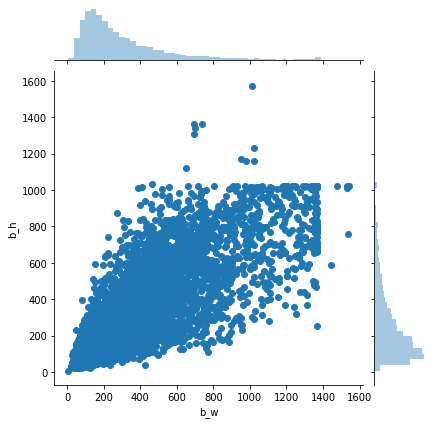

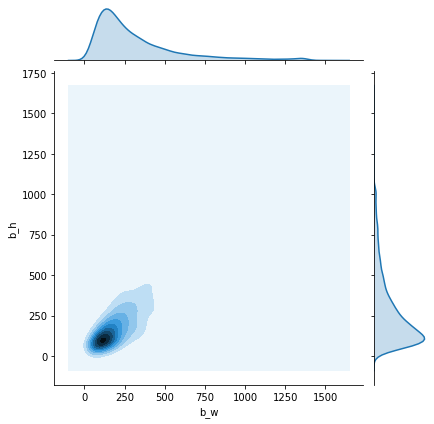

In [41]:
#Joint Plot of b_w and b_h
sns.jointplot(x="b_w", y="b_h", data=data)
sns.jointplot(x="b_w", y="b_h", data=data, kind='kde')

### Calculate the base box size!


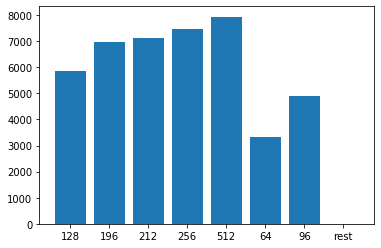

In [36]:
def count_base_size(width, height, input_array=[64,96,128,196,212,256,512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    import itertools
    for w,h in zip(width,height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result
    
D = count_base_size(data["b_w"].tolist(), data["b_h"].tolist())
import collections
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')  # python 2.x
plt.xticks(range(len(OD)), OD.keys())  # in python 2.x

plt.show()


In [37]:
print(OD)

OrderedDict([('128', 5865), ('196', 6972), ('212', 7115), ('256', 7451), ('512', 7935), ('64', 3340), ('96', 4884), ('rest', 0)])


In [12]:
# Area Scale
base_box = 256*256
data['b_area_scale'] = (data['w']*data['h']/(base_box)).apply(np.sqrt)
data.describe()

,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale
count,7935.00000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000
mean,438.90775,335.125898,169.837933,142.419534,269.228607,228.454820,100.390674,87.035287,1061.525646,810.311783,248.460433,214.243227,1.314735,0.356376
std,119.70912,91.807456,120.186694,86.695812,125.045422,96.748531,85.418842,72.775482,62.601003,56.548647,207.563056,172.517680,0.700810,0.287990
min,150.00000,144.000000,1.000000,1.000000,12.000000,12.000000,2.000000,2.000000,533.000000,681.000000,5.335000,5.333333,0.205470,0.007812
25%,400.00000,300.000000,83.000000,84.000000,184.500000,166.000000,43.000000,35.000000,1067.000000,800.000000,106.700000,88.000000,0.842661,0.152294
50%,400.00000,300.000000,155.000000,134.000000,261.000000,222.000000,73.000000,64.000000,1067.000000,800.000000,180.056250,156.666667,1.115102,0.267742
75%,400.00000,300.000000,238.000000,190.000000,336.000000,279.000000,127.000000,116.000000,1067.000000,800.000000,317.432500,282.666667,1.586282,0.458880
max,800.00000,800.000000,763.000000,672.000000,800.000000,800.000000,799.000000,785.000000,1280.000000,1280.000000,1199.000000,1107.200000,11.059010,2.540564


In [13]:
# TF scale
base_anchor = 256
data['tf_scale'] = data['b_h']*(data['b_ar']).apply(np.sqrt)/base_anchor
data['tf_scale_2']= data['b_w']/((data['b_ar']).apply(np.sqrt)*base_anchor)
data.describe()

,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale,tf_scale,tf_scale_2
count,7935.00000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000,7935.000000
mean,438.90775,335.125898,169.837933,142.419534,269.228607,228.454820,100.390674,87.035287,1061.525646,810.311783,248.460433,214.243227,1.314735,0.356376,0.879694,0.879694
std,119.70912,91.807456,120.186694,86.695812,125.045422,96.748531,85.418842,72.775482,62.601003,56.548647,207.563056,172.517680,0.700810,0.287990,0.692266,0.692266
min,150.00000,144.000000,1.000000,1.000000,12.000000,12.000000,2.000000,2.000000,533.000000,681.000000,5.335000,5.333333,0.205470,0.007812,0.020837,0.020837
25%,400.00000,300.000000,83.000000,84.000000,184.500000,166.000000,43.000000,35.000000,1067.000000,800.000000,106.700000,88.000000,0.842661,0.152294,0.380627,0.380627
50%,400.00000,300.000000,155.000000,134.000000,261.000000,222.000000,73.000000,64.000000,1067.000000,800.000000,180.056250,156.666667,1.115102,0.267742,0.655608,0.655608
75%,400.00000,300.000000,238.000000,190.000000,336.000000,279.000000,127.000000,116.000000,1067.000000,800.000000,317.432500,282.666667,1.586282,0.458880,1.146012,1.146012
max,800.00000,800.000000,763.000000,672.000000,800.000000,800.000000,799.000000,785.000000,1280.000000,1280.000000,1199.000000,1107.200000,11.059010,2.540564,3.820948,3.820948


In [14]:
data.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax',
       'w', 'h', 'new_w', 'new_h', 'b_w', 'b_h', 'b_ar', 'b_area_scale',
       'tf_scale', 'tf_scale_2'],
      dtype='object')

## Clusterring

### Eucledian Distance Based Clusterring

### One by One (AR and Scale Separately)

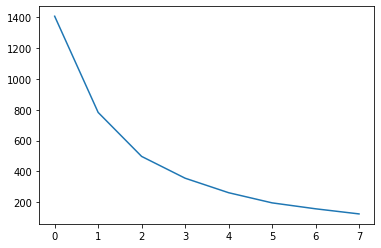

In [15]:
# Aspect Ratio
X = data.iloc[:,14].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [16]:
print(data.columns[14])

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
print("Aspect Ratios:\n")
print(labels.cluster_centers_)

b_ar
Aspect Ratios:

[[1.42511633]
 [2.27493239]
 [0.83126058]
 [3.6128397 ]]


In [17]:
# Correlation Check (ignore!)

x = data['w']/data['h']

data['b_ar'].corr(x)

0.9999999565663664

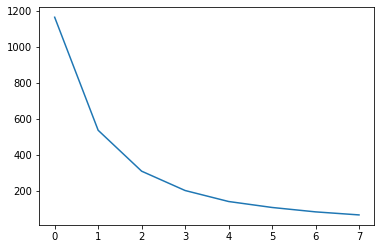

In [18]:

# TF_Scale Clusterring
X = data.iloc[:,16].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

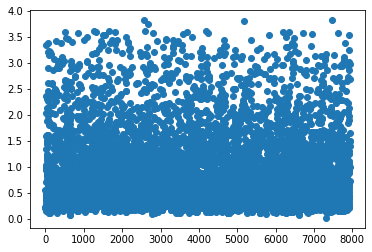

In [19]:
# Plot of different scales
plt.plot(X, 'o')

In [20]:
print(data.columns[16])

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

tf_scale


array([[0.92194601],
       [0.39131406],
       [2.79903298],
       [1.66806119]])

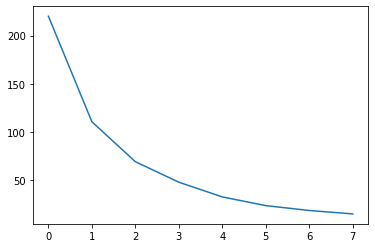

In [21]:
# area_Scale
X = data.iloc[:,15].values
X = X.reshape(-1,1)


loss = []
from sklearn.cluster import KMeans
for i in range(2,10):
    K = KMeans(i, random_state=1)
    labels = K.fit(X)
    loss.append(labels.inertia_)

plt.plot(loss)

In [22]:
print(data.columns[15])

from sklearn.cluster import KMeans
K = KMeans(4, random_state=1)
labels = K.fit(X)
labels.cluster_centers_

b_area_scale


array([[0.37925993],
       [1.20394822],
       [0.15709326],
       [0.70048938]])

## Clusterring using both width & height

Index(['b_w', 'b_h'], dtype='object')


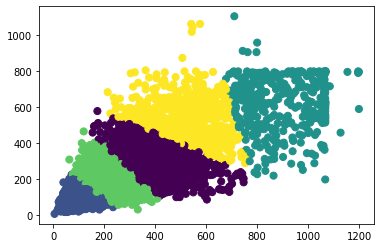

In [23]:
print(data.columns[12:14])
X = data.as_matrix(columns=data.columns[12:14])

from sklearn.cluster import KMeans
K = KMeans(5, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_,
            s=50, cmap='viridis');

In [24]:
out = labels.cluster_centers_

ar = out[:,0]/out[:,1]
scale = out[:,1]*np.sqrt(ar)/256

print("Aspect Ratios: ")
print (ar)

print ("Scales: ")
print (scale)

Aspect Ratios: 
[1.20848484 1.18739786 1.45160389 1.09131089 0.95259292]
Scales: 
[1.34799527 0.36394955 2.90489429 0.79616168 2.06421995]


### IOU based clusterring

In [27]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [29]:
print(data.columns[12:14])
X = data.as_matrix(columns=data.columns[12:14])

# Cluster with 4 centers
cl = kmeans(X, 4)
print(cl)

Index(['b_w', 'b_h'], dtype='object')
[[562.8425     501.33333333]
 [149.38       128.        ]
 [ 77.3575      64.        ]
 [268.4171875  248.        ]]


In [31]:
ar_iou = cl[:,0]/cl[:,1]

print(ar_iou)


scale_iou = cl[:,1]*np.sqrt(ar_iou)/256
print(scale_iou)

[1.12269116 1.16703125 1.20871094 1.08232737]
[2.07499363 0.5401461  0.27485348 1.00783871]
